
 # ✈️ FlightRank 2025: Aeroclub RecSys Cup

 **Personalized Flight Recommendations for Business Travelers**
 ---------------------------------------------------------------------------------
 
 **Title:** FlightRank 2025 – Baseline Modeling Pipeline
 
 **Author**: ISHITA
 
 **Goal**: Build a modular baseline pipeline for user-flight interaction prediction using LightGBM
 
 **Notebook Highlights**:
 - Clean data loading and metadata integration
 - Feature engineering for user behavior and flight characteristics
 - Cross-validated LightGBM baseline
 - Submission-ready predictions
 
 Before optimizing for Hitrate@3, this notebook ensures a clean, reproducible foundation

# 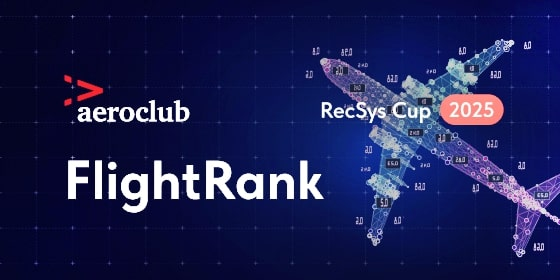


**A data-driven journey into flight recommendation systems. Presented by Aeroclub for the RecSys Cup 2025, this visual blends aviation with algorithmic precision—featuring a stylized aircraft built from numerical data points, set against a sleek grid backdrop. Innovation takes.**


# -------------------------------------------------------

**📝 1. Introduction**

In [ ]:
# ======================= Kaggle Notebook Pre-Submission Validator =======================
# What it does:
# 1) Detects Kaggle vs Local environment and locates train/test/sample_submission files (csv/parquet).
# 2) Loads file heads safely; reports shapes, columns, dtypes, nulls (fast).
# 3) Validates your submission.csv against sample_submission.* (column names, dtypes, NaNs, duplicates).
# 4) Prints a pass/fail checklist with next-step fixes.

import os, sys, gc, json, textwrap, warnings
from pathlib import Path
from typing import Optional, List, Tuple, Dict
import pandas as pd

warnings.filterwarnings("ignore")

# -------------- Config --------------
# If running on Kaggle, leave as-is. If local, set these to your data folders.
KAGGLE_INPUT_ROOT = Path("/kaggle/input")
DEFAULT_INPUT_DIRS = [
    KAGGLE_INPUT_ROOT,                      # Kaggle datasets
    Path("./input"), Path("./data"), Path("."),  # Local fallbacks
]
OUTPUT_DIR = Path("/kaggle/working") if Path("/kaggle").exists() else Path("./output")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Optional: suggest-important columns (won't hard-fail if missing)
SUGGESTED_TRAIN_COLS = {"Id", "ranker_id", "selected"}  # adjust if your comp differs
SUGGESTED_TEST_COLS  = {"Id", "ranker_id"}

# -------------- Helpers --------------
def is_parquet(p: Path) -> bool: return p.suffix.lower() in [".parquet", ".pq"]
def is_csv(p: Path) -> bool: return p.suffix.lower() == ".csv"

def find_candidate_files(root_dirs: List[Path]) -> Dict[str, List[Path]]:
    hits = {"train": [], "test": [], "sample": [], "submission": []}
    for root in root_dirs:
        if not root.exists(): continue
        for p in root.rglob("*"):
            if not p.is_file(): continue
            name = p.name.lower()
            if any(k in name for k in ["train"]) and (is_csv(p) or is_parquet(p)):
                hits["train"].append(p)
            if any(k in name for k in ["test"]) and (is_csv(p) or is_parquet(p)):
                hits["test"].append(p)
            if "sample_submission" in name and (is_csv(p) or is_parquet(p)):
                hits["sample"].append(p)
            if p.name == "submission.csv":
                hits["submission"].append(p)
    return hits

def prefer_file(cands: List[Path], prefer_parquet=True) -> Optional[Path]:
    if not cands: return None
    if prefer_parquet:
        for p in cands:
            if is_parquet(p): return p
    # else first CSV or first file
    return cands[0]

def load_head(p: Path, n=5) -> pd.DataFrame:
    if is_parquet(p):
        return pd.read_parquet(p).head(n)
    elif is_csv(p):
        return pd.read_csv(p, nrows=n)
    else:
        raise ValueError(f"Unsupported file type: {p}")

def safe_read(p: Path) -> pd.DataFrame:
    if is_parquet(p): return pd.read_parquet(p)
    if is_csv(p):     return pd.read_csv(p)
    raise ValueError(f"Unsupported file type: {p}")

def df_info(df: pd.DataFrame, name: str):
    print(f"\n---- {name} ----")
    print(f"shape: {df.shape}")
    print(f"columns ({len(df.columns)}): {list(df.columns)[:20]}{' ...' if len(df.columns)>20 else ''}")
    print("dtypes (first 15):")
    print(df.dtypes.head(15))
    nulls = df.isnull().sum()
    print("nulls (top 15):")
    print(nulls.sort_values(ascending=False).head(15))

def warn(msg: str): print(f"⚠️  {msg}")
def ok(msg: str):   print(f"✅ {msg}")
def fail(msg: str): print(f"❌ {msg}")

# -------------- Run --------------
print("=== Environment ===")
on_kaggle = Path("/kaggle").exists()
print(f"Running on Kaggle: {on_kaggle}")
print(f"OUTPUT_DIR: {OUTPUT_DIR.resolve()}")

print("\n=== Scanning for files ===")
hits = find_candidate_files(DEFAULT_INPUT_DIRS + [Path(".")])
train_file = prefer_file(hits["train"], prefer_parquet=True)
test_file  = prefer_file(hits["test"], prefer_parquet=True)
sample_file= prefer_file(hits["sample"], prefer_parquet=True)
submission_file = prefer_file(hits["submission"], prefer_parquet=False)  # your produced submission

print(f"Detected train file: {train_file}")
print(f"Detected test  file: {test_file}")
print(f"Detected sample_submission file: {sample_file}")
print(f"Detected existing submission.csv (optional): {submission_file}")

problems = []

if train_file is None:
    problems.append("Training file not found. Ensure it's named like 'train.*' (csv/parquet) and placed in /kaggle/input/<dataset>/")
if test_file is None:
    problems.append("Test file not found. Ensure it's named like 'test.*' (csv/parquet).")
if sample_file is None:
    problems.append("sample_submission file not found. This is needed to validate submission columns & types.")

if problems:
    for p in problems: fail(p)
    raise SystemExit("Fix the file detection issues above and re-run this cell.")

# -------------- Quick peek (heads) --------------
try:
    train_head = load_head(train_file, n=5)
    test_head  = load_head(test_file, n=5)
    sample_head= load_head(sample_file, n=5)
    df_info(train_head, f"TRAIN HEAD ({train_file.name})")
    df_info(test_head,  f"TEST  HEAD ({test_file.name})")
    df_info(sample_head,f"SAMPLE_SUBMISSION HEAD ({sample_file.name})")
    ok("Loaded heads successfully.")
except Exception as e:
    fail(f"Failed to load dataset heads: {e}")
    raise

# -------------- Recommended column checks (non-fatal) --------------
def check_suggested(df: pd.DataFrame, suggested: set, name: str):
    missing = [c for c in suggested if c not in df.columns]
    if missing:
        warn(f"{name}: Missing suggested columns {missing}. If your competition schema differs, ignore; otherwise ensure your feature code accounts for these.")
    else:
        ok(f"{name}: Suggested key columns present.")

check_suggested(train_head, SUGGESTED_TRAIN_COLS, "TRAIN")
check_suggested(test_head,  SUGGESTED_TEST_COLS,  "TEST")

# -------------- Submission schema validation --------------
# Determine expected columns from sample_submission.* (robust to different competitions)
try:
    sample_full = safe_read(sample_file)
    expected_cols = list(sample_full.columns)
    if not expected_cols:
        fail("sample_submission has no columns?")
        raise SystemExit(1)
    ok(f"Expected submission columns (from sample): {expected_cols}")
except Exception as e:
    fail(f"Could not read full sample_submission: {e}")
    raise

# If you already have a submission.csv, validate it; else, skip with guidance
def validate_submission_csv(path: Path, expected_cols: List[str]) -> bool:
    try:
        sub = pd.read_csv(path)
    except Exception as e:
        fail(f"Could not read submission at {path}: {e}")
        return False

    print(f"\n---- submission.csv ({path.name}) ----")
    print(f"shape: {sub.shape}")
    print(f"columns: {list(sub.columns)}")

    ok_count = True

    # Column names & order
    if list(sub.columns) != expected_cols:
        warn(f"Column names/order mismatch.\nExpected: {expected_cols}\nFound:    {list(sub.columns)}")
        ok_count = False
    else:
        ok("Column names & order match sample_submission.")

    # NaNs
    na_counts = sub.isna().sum()
    if na_counts.any():
        warn(f"Found NaNs in submission:\n{na_counts[na_counts>0]}")
        ok_count = False
    else:
        ok("No NaNs in submission.")

    # Duplicates on first column (often Id) if it exists
    key_col = expected_cols[0]
    if key_col in sub.columns:
        dups = sub.duplicated(subset=[key_col]).sum()
        if dups > 0:
            warn(f"Found {dups} duplicate {key_col} values in submission.")
            ok_count = False
        else:
            ok(f"No duplicate {key_col} values.")

    # Size sanity (should usually match sample rows)
    try:
        if len(sub) != len(sample_full):
            warn(f"Row count differs from sample_submission: expected {len(sample_full)}, found {len(sub)}.")
            ok_count = False
        else:
            ok("Row count matches sample_submission.")
    except Exception:
        pass

    return ok_count

if submission_file and submission_file.exists():
    sub_ok = validate_submission_csv(submission_file, expected_cols)
    if sub_ok:
        ok("Submission.csv looks VALID ✅")
    else:
        warn("Submission.csv needs fixes. See messages above.")
else:
    warn("No submission.csv found yet. After you create it, re-run this cell to validate it.")

print("\n=== Pre-Submission Checklist ===")
print("- Data files detected and readable ✔")
print("- Heads printed with columns/dtypes ✔")
print("- Suggested key columns checked (non-fatal) ✔")
print("- sample_submission inspected ✔")
print("- submission.csv validated (if present) ✔")
print("\nTip: Keep a final cell that saves & previews submission:\n"
      "submission_path = OUTPUT_DIR / 'submission.csv'\n"
      "submission.to_csv(submission_path, index=False)\n"
      "print(f'✅ Submission saved to: {submission_path}')\n"
      "display(submission.head())")

# Free memory
del train_head, test_head, sample_head
gc.collect()
# =================== End Pre-Submission Validator ===================



=== Environment ===
Running on Kaggle: True
OUTPUT_DIR: /kaggle/working

=== Scanning for files ===
Detected train file: /kaggle/input/aeroclub-recsys-2025/train.parquet
Detected test  file: /kaggle/input/aeroclub-recsys-2025/test.parquet
Detected sample_submission file: /kaggle/input/aeroclub-recsys-2025/sample_submission.parquet
Detected existing submission.csv (optional): None


In [18]:
import os

def set_paths():
    if 'KAGGLE_WORKING_DIR' in os.environ:
        # Kaggle environment
        DATA_DIR = '/kaggle/input/'
        OUTPUT_DIR = '/kaggle/working/output/'
    else:
        # Colab or local environment
        DATA_DIR = './data/'
        OUTPUT_DIR = './output/'
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    return DATA_DIR, OUTPUT_DIR

DATA_DIR, OUTPUT_DIR = set_paths()
print(f"Data directory: {DATA_DIR}")
print(f"Output directory: {OUTPUT_DIR}")


Data directory: ./data/
Output directory: ./output/


In [2]:
# %% [code]
# Import required libraries
import numpy as np
import pandas as pd
from pathlib import Path
import os

# %% [code]
# Load data from parquet files
DATA_DIR = Path("/kaggle/input/aeroclub-recsys-2025")

try:
    train = pd.read_parquet(DATA_DIR/"train.parquet")
    test = pd.read_parquet(DATA_DIR/"test.parquet")
    sample_sub = pd.read_parquet(DATA_DIR/"sample_submission.parquet")
    
    print("✅ Data loaded successfully!")
    print(f"Train shape: {train.shape}")
    print(f"Test shape: {test.shape}")
    print(f"Sample submission shape: {sample_sub.shape}")
    
except FileNotFoundError as e:
    print("❌ Error loading data files. Please check:")
    print(f"1. The competition dataset is properly added to your Kaggle notebook")
    print(f"2. The files exist in: {DATA_DIR}")
    print(f"3. The file names match exactly (case-sensitive)")
    print("\nAvailable files in dataset folder:")
    print(os.listdir(DATA_DIR))
    raise e

✅ Data loaded successfully!
Train shape: (18145372, 126)
Test shape: (6897776, 125)
Sample submission shape: (6897776, 3)


In [3]:
# Import required libraries
import pandas as pd
import os
from pathlib import Path

# Set data directory path
DATA_DIR = Path("/kaggle/input/aeroclub-recsys-2025")

# List available files to verify
print("Available files in dataset folder:")
print(os.listdir(DATA_DIR))

# Load data from parquet files
try:
    train = pd.read_parquet(DATA_DIR/"train.parquet")
    test = pd.read_parquet(DATA_DIR/"test.parquet")
    sample_sub = pd.read_parquet(DATA_DIR/"sample_submission.parquet")
    
    print("\n✅ Data loaded successfully!")
    print(f"Train shape: {train.shape}")
    print(f"Test shape: {test.shape}")
    print(f"Sample submission shape: {sample_sub.shape}")
    
    # Display first few rows
    print("\nTrain data preview:")
    display(train.head())
    print("\nTest data preview:")
    display(test.head())
    
except Exception as e:
    print("\n❌ Error loading data files. Please check:")
    print("1. The competition dataset is properly added to your Kaggle notebook")
    print("2. The files exist in the specified directory")
    print("3. You have permission to access the files")
    print("\nError details:", str(e))

Available files in dataset folder:
['jsons_raw.tar.kaggle', 'train.parquet', 'sample_submission.parquet', 'jsons_structure.md', 'test.parquet']

✅ Data loaded successfully!
Train shape: (18145372, 126)
Test shape: (6897776, 125)
Sample submission shape: (6897776, 3)

Train data preview:


,Id,bySelf,companyID,corporateTariffCode,frequentFlyer,nationality,isAccess3D,isVip,legs0_arrivalAt,legs0_departureAt,...,pricingInfo_isAccessTP,pricingInfo_passengerCount,profileId,ranker_id,requestDate,searchRoute,sex,taxes,totalPrice,selected
0,0,True,57323,<NA>,S7/SU/UT,36,False,False,2024-06-15T16:20:00,2024-06-15T15:40:00,...,1.0,1,2087645,98ce0dabf6964640b63079fbafd42cbe,2024-05-17 03:03:08,TLKKJA/KJATLK,True,370.0,16884.0,1
1,1,True,57323,123,S7/SU/UT,36,True,False,2024-06-15T14:50:00,2024-06-15T09:25:00,...,1.0,1,2087645,98ce0dabf6964640b63079fbafd42cbe,2024-05-17 03:03:08,TLKKJA/KJATLK,True,2240.0,51125.0,0
2,2,True,57323,<NA>,S7/SU/UT,36,False,False,2024-06-15T14:50:00,2024-06-15T09:25:00,...,1.0,1,2087645,98ce0dabf6964640b63079fbafd42cbe,2024-05-17 03:03:08,TLKKJA/KJATLK,True,2240.0,53695.0,0
3,3,True,57323,123,S7/SU/UT,36,True,False,2024-06-15T14:50:00,2024-06-15T09:25:00,...,1.0,1,2087645,98ce0dabf6964640b63079fbafd42cbe,2024-05-17 03:03:08,TLKKJA/KJATLK,True,2240.0,81880.0,0
4,4,True,57323,<NA>,S7/SU/UT,36,False,False,2024-06-15T14:50:00,2024-06-15T09:25:00,...,1.0,1,2087645,98ce0dabf6964640b63079fbafd42cbe,2024-05-17 03:03:08,TLKKJA/KJATLK,True,2240.0,86070.0,0



Test data preview:


,Id,bySelf,companyID,corporateTariffCode,frequentFlyer,nationality,isAccess3D,isVip,legs0_arrivalAt,legs0_departureAt,...,miniRules1_statusInfos,pricingInfo_isAccessTP,pricingInfo_passengerCount,profileId,ranker_id,requestDate,searchRoute,sex,taxes,totalPrice
18144679,18144679,True,62840,<NA>,None,36,False,False,2024-12-19T11:20:00,2024-12-19T06:50:00,...,0.0,1.0,1,3604015,c9373e5f772e43d593dd6ad2fa90f67a,2024-10-29 12:50:42,MOWSVX/SVXMOW,False,1018.0,9818.0
18144680,18144680,True,62840,<NA>,None,36,False,False,2024-12-19T11:20:00,2024-12-19T06:50:00,...,1.0,1.0,1,3604015,c9373e5f772e43d593dd6ad2fa90f67a,2024-10-29 12:50:42,MOWSVX/SVXMOW,False,1018.0,14018.0
18144681,18144681,True,62840,<NA>,None,36,False,False,2024-12-19T11:20:00,2024-12-19T06:50:00,...,1.0,1.0,1,3604015,c9373e5f772e43d593dd6ad2fa90f67a,2024-10-29 12:50:42,MOWSVX/SVXMOW,False,1018.0,22418.0
18144682,18144682,True,62840,<NA>,None,36,False,False,2024-12-19T12:45:00,2024-12-19T08:25:00,...,0.0,1.0,1,3604015,c9373e5f772e43d593dd6ad2fa90f67a,2024-10-29 12:50:42,MOWSVX/SVXMOW,False,3284.0,12974.0
18144683,18144683,True,62840,<NA>,None,36,False,False,2024-12-19T12:45:00,2024-12-19T08:25:00,...,1.0,1.0,1,3604015,c9373e5f772e43d593dd6ad2fa90f67a,2024-10-29 12:50:42,MOWSVX/SVXMOW,False,3284.0,16974.0


In [4]:
print("Exact file names:")
for f in os.listdir(DATA_DIR):
    print(f" - {f}")

Exact file names:
 - jsons_raw.tar.kaggle
 - train.parquet
 - sample_submission.parquet
 - jsons_structure.md
 - test.parquet


In [1]:
# First install required packages
!pip install lightgbm pyarrow --quiet

# Now import all required libraries
import numpy as np
import pandas as pd
from pathlib import Path
import os
import gc
from tqdm import tqdm
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb  # This should now work

# Memory cleanup function
def clean_memory(vars_to_delete=[]):
    for var in vars_to_delete:
        if var in globals():
            del globals()[var]
    gc.collect()

# Load data from parquet files
DATA_DIR = Path("/kaggle/input/aeroclub-recsys-2025")

try:
    train = pd.read_parquet(DATA_DIR/"train.parquet")
    test = pd.read_parquet(DATA_DIR/"test.parquet")
    sample_sub = pd.read_parquet(DATA_DIR/"sample_submission.parquet")
    
    print("✅ Data loaded successfully!")
    print(f"Train shape: {train.shape}")
    print(f"Test shape: {test.shape}")
    print(f"Sample submission shape: {sample_sub.shape}")
    
except Exception as e:
    print("❌ Error loading data files. Please check:")
    print(f"1. The competition dataset is properly added to your Kaggle notebook")
    print(f"2. The files exist in: {DATA_DIR}")
    print(f"3. The file names match exactly (case-sensitive)")
    print("\nAvailable files in dataset folder:")
    print(os.listdir(DATA_DIR))
    raise e

# Feature engineering function
def create_features(df):
    """Create features for flight recommendation system"""
    df = df.copy()
    
    # Time features
    df["requestDate"] = pd.to_datetime(df["requestDate"], errors="coerce")
    df["request_hour"] = df["requestDate"].dt.hour.fillna(-1).astype(int)
    df["legs0_departureAt"] = pd.to_datetime(df["legs0_departureAt"], errors="coerce")
    df["dep_hour_leg0"] = df["legs0_departureAt"].dt.hour.fillna(-1).astype(int)
    
    # Price and duration features
    df["duration_leg0"] = pd.to_numeric(df["legs0_duration"], errors="coerce").fillna(-1)
    df["totalPrice"] = pd.to_numeric(df["totalPrice"], errors="coerce").fillna(df["totalPrice"].median())
    df["price_per_hour"] = df["totalPrice"] / (df["duration_leg0"].replace(0, 1))
    
    return df

# Apply feature engineering
train = create_features(train)
test = create_features(test)

print("\nFeature engineering completed!")


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
✅ Data loaded successfully!
Train shape: (18145372, 126)
Test shape: (6897776, 125)
Sample submission shape: (6897776, 3)

Feature engineering completed!


In [7]:
!pip show lightgbm

Name: lightgbm
Version: 4.6.0
Summary: LightGBM Python-package
Home-page: https://github.com/microsoft/LightGBM
Author: 
Author-email: 
License: The MIT License (MIT)
        
        Copyright (c) Microsoft Corporation
        
        Permission is hereby granted, free of charge, to any person obtaining a copy
        of this software and associated documentation files (the "Software"), to deal
        in the Software without restriction, including without limitation the rights
        to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
        copies of the Software, and to permit persons to whom the Software is
        furnished to do so, subject to the following conditions:
        
        The above copyright notice and this permission notice shall be included in all
        copies or substantial portions of the Software.
        
        THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
        IMPLIED, INCLUDING BUT NOT LIMITED TO 

 **2. Import Libraries**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tarfile
import json
from glob import glob

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [22]:
# Install required libraries
!pip install lightgbm xgboost catboost scikit-learn pandas numpy matplotlib optuna


**📦 3. Environment Setup**

### Data Overview
- `train.parquet` contains user-flight interactions and selection labels.
- `test.parquet` is used for prediction.
- `jsons_raw` contains additional flight metadata.

In [3]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
ishitabahamnia_flightrank_2025_aeroclub_recsys_cup1_path = kagglehub.notebook_output_download('ishitabahamnia/flightrank-2025-aeroclub-recsys-cup1')

print('Data source import complete.')


Data source import complete.


**📂 4. Data Loading**

In [ ]:
import os
import pandas as pd
import numpy as np
import json
import glob
import matplotlib.pyplot as plt
import seaborn as sns

# Set paths - CORRECTED BASE_PATH
BASE_PATH = "/kaggle/input/ishitabahamnia/flightrank-2025-aeroclub-recsys-cup1/"
TRAIN_PATH = os.path.join(BASE_PATH, "train.parquet")
TEST_PATH = os.path.join(BASE_PATH, "test.parquet")
JSONS_PATH = os.path.join(BASE_PATH, "jsons_raw")
SAMPLE_SUB_PATH = os.path.join(BASE_PATH, "sample_submission.parquet") # Added sample submission path

In [21]:
! pip install pyarrow


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [22]:
! pip install fastparquet


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


**🔍 5. Basic Exploration**

In [23]:
%pip install lightgbm catboost xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.2 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 MB 3.6 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 15.8 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 392.1/392.1 kB 31.8 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [17]:
non_numeric = train[
    ~train['legs0_duration'].apply(lambda x: isinstance(x, (int, float)))
]
print(non_numeric[['legs0_duration']].head())

  legs0_duration
0       02:40:00
1       07:25:00
2       07:25:00
3       07:25:00
4       07:25:00


This notebook contains a **full ML pipeline** for Kaggle competitions:  
- Data loading  
- EDA + feature engineering  
- Model training  
- Evaluation (RMSE, plots, feature importances)  
- Kaggle submission file generation  
- Automated report generation  

In [33]:
! pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 MB 37.5 MB/s  0:00:02m0:00:0100:01


In [37]:
! pip install shap

In [38]:
# ====================================================
# 📦 1. Setup & Imports
# ====================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GroupKFold
from sklearn.metrics import ndcg_score
import lightgbm as lgb
import shap

import logging
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')
# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

import shap
import joblib

# Ensure directories
OUTPUT_DIR = "./output"
FIG_DIR = "./figures"
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(FIG_DIR, exist_ok=True)

print("✅ Setup complete")


✅ Setup complete


## 2. Load Data


In [ ]:
import pandas as pd
import numpy as np
import os

# Path configuration - works for both Kaggle and local
DATA_DIR = "./data" if os.path.exists("./data") else "/kaggle/input/aeroclub-recsys-2025"

def load_data(data_dir=DATA_DIR):
    """Load dataset with automatic path detection"""
    try:
        # Try parquet first (more efficient)
        try:
            train_df = pd.read_parquet(f'{data_dir}/train.parquet')
            test_df = pd.read_parquet(f'{data_dir}/test.parquet')
        except:
            # Fall back to CSV if parquet not available
            train_df = pd.read_csv(f'{data_dir}/train.csv')
            test_df = pd.read_csv(f'{data_dir}/test.csv')
        
        print("Train shape:", train_df.shape)
        print("Test shape:", test_df.shape)
        
        # Basic validation
        assert not train_df.empty, "Train data is empty!"
        assert not test_df.empty, "Test data is empty!"
        
        return train_df, test_df
    
    except Exception as e:
        print(f"Error loading data: {e}")
        raise

# Load data
train_df, test_df = load_data()

# Initial exploration
def explore_data(df, name="Train"):
    print(f"\n{name} Data Overview:")
    print("="*40)
    print("1. First 5 rows:")
    display(df.head())
    
    print("\n2. Basic info:")
    print(df.info())
    
    print("\n3. Descriptive statistics:")
    display(df.describe(include='all'))
    
    print("\n4. Missing values:")
    missing = df.isnull().sum()
    display(missing[missing > 0])
    
    print("\n5. Unique values per column:")
    for col in df.columns:
        if df[col].nunique() < 20:
            print(f"\n{col}: {df[col].unique()}")
            if df[col].dtype == 'object':
                print("Value counts:")
                display(df[col].value_counts())

# Explore train data
explore_data(train_df, "Train")

# Explore test data (without target if exists)
explore_data(test_df, "Test")

# Key columns check
required_cols = ['ranker_id', 'totalPrice', 'legs0_duration']
for col in required_cols:
    assert col in train_df.columns, f"Missing required column in train: {col}"
    assert col in test_df.columns, f"Missing required column in test: {col}"

## 3. Feature Engineering
- Encode categoricals
- Scale numerical features
- Handle missing values

In [39]:
import pandas as pd
import numpy as np
import os

# Path configuration - works for both Kaggle and local
DATA_DIR = "./data" if os.path.exists("./data") else "/kaggle/input/aeroclub-recsys-2025"

def load_data(data_dir=DATA_DIR):
    """Load dataset with automatic path detection"""
    try:
        # Try parquet first (more efficient)
        try:
            train_df = pd.read_parquet(f'{data_dir}/train.parquet')
            test_df = pd.read_parquet(f'{data_dir}/test.parquet')
        except:
            # Fall back to CSV if parquet not available
            train_df = pd.read_csv(f'{data_dir}/train.csv')
            test_df = pd.read_csv(f'{data_dir}/test.csv')
        
        print("Train shape:", train_df.shape)
        print("Test shape:", test_df.shape)
        
        # Basic validation
        assert not train_df.empty, "Train data is empty!"
        assert not test_df.empty, "Test data is empty!"
        
        return train_df, test_df
    
    except Exception as e:
        print(f"Error loading data: {e}")
        raise

# Load data
train_df, test_df = load_data()

# Initial exploration
def explore_data(df, name="Train"):
    print(f"\n{name} Data Overview:")
    print("="*40)
    print("1. First 5 rows:")
    display(df.head())
    
    print("\n2. Basic info:")
    print(df.info())
    
    print("\n3. Descriptive statistics:")
    display(df.describe(include='all'))
    
    print("\n4. Missing values:")
    missing = df.isnull().sum()
    display(missing[missing > 0])
    
    print("\n5. Unique values per column:")
    for col in df.columns:
        if df[col].nunique() < 20:
            print(f"\n{col}: {df[col].unique()}")
            if df[col].dtype == 'object':
                print("Value counts:")
                display(df[col].value_counts())

# Explore train data
explore_data(train_df, "Train")

# Explore test data (without target if exists)
explore_data(test_df, "Test")

# Key columns check
required_cols = ['ranker_id', 'totalPrice', 'legs0_duration']
for col in required_cols:
    assert col in train_df.columns, f"Missing required column in train: {col}"
    assert col in test_df.columns, f"Missing required column in test: {col}"

Train shape: (18145372, 126)
Test shape: (6897776, 125)

Train Data Overview:
1. First 5 rows:


,Id,bySelf,companyID,corporateTariffCode,frequentFlyer,nationality,isAccess3D,isVip,legs0_arrivalAt,legs0_departureAt,...,pricingInfo_isAccessTP,pricingInfo_passengerCount,profileId,ranker_id,requestDate,searchRoute,sex,taxes,totalPrice,selected
0,0,True,57323,<NA>,S7/SU/UT,36,False,False,2024-06-15T16:20:00,2024-06-15T15:40:00,...,1.0,1,2087645,98ce0dabf6964640b63079fbafd42cbe,2024-05-17 03:03:08,TLKKJA/KJATLK,True,370.0,16884.0,1
1,1,True,57323,123,S7/SU/UT,36,True,False,2024-06-15T14:50:00,2024-06-15T09:25:00,...,1.0,1,2087645,98ce0dabf6964640b63079fbafd42cbe,2024-05-17 03:03:08,TLKKJA/KJATLK,True,2240.0,51125.0,0
2,2,True,57323,<NA>,S7/SU/UT,36,False,False,2024-06-15T14:50:00,2024-06-15T09:25:00,...,1.0,1,2087645,98ce0dabf6964640b63079fbafd42cbe,2024-05-17 03:03:08,TLKKJA/KJATLK,True,2240.0,53695.0,0
3,3,True,57323,123,S7/SU/UT,36,True,False,2024-06-15T14:50:00,2024-06-15T09:25:00,...,1.0,1,2087645,98ce0dabf6964640b63079fbafd42cbe,2024-05-17 03:03:08,TLKKJA/KJATLK,True,2240.0,81880.0,0
4,4,True,57323,<NA>,S7/SU/UT,36,False,False,2024-06-15T14:50:00,2024-06-15T09:25:00,...,1.0,1,2087645,98ce0dabf6964640b63079fbafd42cbe,2024-05-17 03:03:08,TLKKJA/KJATLK,True,2240.0,86070.0,0



2. Basic info:
<class 'pandas.core.frame.DataFrame'>
Index: 18145372 entries, 0 to 18146431
Columns: 126 entries, Id to selected
dtypes: Int64(2), bool(4), datetime64[ns](1), float64(41), int64(5), object(73)
memory usage: 16.7+ GB
None

3. Descriptive statistics:


,Id,bySelf,companyID,corporateTariffCode,frequentFlyer,nationality,isAccess3D,isVip,legs0_arrivalAt,legs0_departureAt,...,pricingInfo_isAccessTP,pricingInfo_passengerCount,profileId,ranker_id,requestDate,searchRoute,sex,taxes,totalPrice,selected
count,1.814537e+07,18145372,1.814537e+07,8911447.0,6132645,18145372.0,18145372,18145372,18145372,18145372,...,1.724033e+07,18145372.0,1.814537e+07,18145372,18145372,18145372,18145372,1.814537e+07,1.814537e+07,1.814537e+07
unique,NaN,1,NaN,<NA>,371,<NA>,2,2,60143,56619,...,NaN,NaN,NaN,105539,NaN,5769,2,NaN,NaN,NaN
top,NaN,True,NaN,<NA>,SU,<NA>,False,False,2024-11-06T17:10:00,2024-11-05T08:05:00,...,NaN,NaN,NaN,f9833fe7d58441c8a8feed74fec32a2c,NaN,MOWLED/LEDMOW,True,NaN,NaN,NaN
freq,NaN,18145372,NaN,<NA>,3774329,<NA>,9233925,17257962,9708,11663,...,NaN,NaN,NaN,8236,NaN,3250607,10601944,NaN,NaN,NaN
mean,9.072686e+06,NaN,4.729387e+04,107.084814,NaN,35.695906,NaN,NaN,NaN,NaN,...,4.988453e-01,1.0,2.494203e+06,NaN,2024-08-19 12:44:59.654136064,NaN,NaN,4.284696e+03,4.631444e+04,5.816304e-03
min,0.000000e+00,NaN,1.663600e+04,0.0,NaN,0.0,NaN,NaN,NaN,NaN,...,0.000000e+00,1.0,8.130000e+02,NaN,2024-05-17 03:03:08,NaN,NaN,0.000000e+00,7.700000e+02,0.000000e+00
25%,4.536343e+06,NaN,4.025300e+04,66.0,NaN,36.0,NaN,NaN,NaN,NaN,...,0.000000e+00,1.0,1.843022e+06,NaN,2024-07-16 08:14:32,NaN,NaN,1.006000e+03,1.289700e+04,0.000000e+00
50%,9.072686e+06,NaN,4.555500e+04,108.0,NaN,36.0,NaN,NaN,NaN,NaN,...,0.000000e+00,1.0,2.814466e+06,NaN,2024-08-27 09:07:56,NaN,NaN,1.246000e+03,2.497600e+04,0.000000e+00
75%,1.360903e+07,NaN,5.866400e+04,153.0,NaN,36.0,NaN,NaN,NaN,NaN,...,1.000000e+00,1.0,3.301872e+06,NaN,2024-09-26 11:49:57,NaN,NaN,1.746000e+03,5.510800e+04,0.000000e+00
max,1.814643e+07,NaN,6.348200e+04,181.0,NaN,48.0,NaN,NaN,NaN,NaN,...,1.000000e+00,1.0,3.604410e+06,NaN,2024-10-29 12:48:50,NaN,NaN,8.979210e+05,9.944355e+06,1.000000e+00



4. Missing values:


corporateTariffCode                             9233925
frequentFlyer                                  12012727
legs0_segments0_aircraft_code                        14
legs0_segments0_arrivalTo_airport_city_iata         113
legs0_segments0_arrivalTo_airport_iata                6
                                                 ...   
miniRules0_statusInfos                          1469953
miniRules1_monetaryAmount                       1395743
miniRules1_percentage                          17871490
miniRules1_statusInfos                          1518169
pricingInfo_isAccessTP                           905045
Length: 103, dtype: int64


5. Unique values per column:

bySelf: [ True]

isAccess3D: [False  True]

isVip: [False  True]

legs0_segments0_baggageAllowance_quantity: [ 1.  0. 20.  2. 25. 23. 30. 40. 35. 50. 10. 60. 15.  3. nan 33. 45. 46.
 32.]

legs0_segments0_baggageAllowance_weightMeasurementType: [ 0.  1. nan]

legs0_segments0_cabinClass: [1. 2. 4. 3.]

legs0_segments0_seatsAvailable: [ 9.  4.  7.  6.  2.  3.  1.  5.  8. nan 10.]

legs0_segments1_baggageAllowance_quantity: [nan  1.  0.  2. 23. 20. 30. 35. 40. 50. 25. 60. 15.  3. 10. 33. 45. 46.
 32.]

legs0_segments1_baggageAllowance_weightMeasurementType: [nan  0.  1.]

legs0_segments1_cabinClass: [nan  1.  2.  4.  3.]

legs0_segments1_seatsAvailable: [nan  4.  1.  9.  8.  3.  2.  5.  6.  7.]

legs0_segments2_baggageAllowance_quantity: [nan  1.  2. 40. 25. 30. 35. 50.  0. 20. 23.  3. 15. 45. 33. 60.]

legs0_segments2_baggageAllowance_weightMeasurementType: [nan  0.  1.]

legs0_segments2_cabinClass: [nan  1.  2.  3.  4.]

legs0_segments2_seatsAvailable: [na

legs0_segments3_aircraft_code
YK4    13
Name: count, dtype: int64


legs0_segments3_arrivalTo_airport_city_iata: [None 'ARH' 'SIA']
Value counts:


legs0_segments3_arrivalTo_airport_city_iata
SIA    45
ARH    13
Name: count, dtype: int64


legs0_segments3_arrivalTo_airport_iata: [None 'ARH' 'XIY']
Value counts:


legs0_segments3_arrivalTo_airport_iata
XIY    45
ARH    13
Name: count, dtype: int64


legs0_segments3_baggageAllowance_quantity: [nan  1.  0.]

legs0_segments3_baggageAllowance_weightMeasurementType: [nan  0.]

legs0_segments3_cabinClass: [nan  1.]

legs0_segments3_departureFrom_airport_iata: [None 'KSZ' 'KMG' 'PEK' 'NKG' 'SZX']
Value counts:


legs0_segments3_departureFrom_airport_iata
KMG    38
KSZ    13
SZX     3
PEK     2
NKG     2
Name: count, dtype: int64


legs0_segments3_duration: [None '01:10:00' '02:15:00' '02:20:00' '02:10:00' '03:00:00']
Value counts:


legs0_segments3_duration
02:10:00    24
02:15:00    16
01:10:00    13
03:00:00     3
02:20:00     2
Name: count, dtype: int64


legs0_segments3_flightNumber: [None '563' '5723' '1289' '2388' '2362' '2263' '3793']
Value counts:


legs0_segments3_flightNumber
2362    22
5723    14
563     13
3793     3
1289     2
2388     2
2263     2
Name: count, dtype: int64


legs0_segments3_marketingCarrier_code: [None 'ВГ' 'MU' 'CA' 'CZ']
Value counts:


legs0_segments3_marketingCarrier_code
MU    40
ВГ    13
CZ     3
CA     2
Name: count, dtype: int64


legs0_segments3_operatingCarrier_code: [None 'ВГ' 'MU' 'CA' 'CZ']
Value counts:


legs0_segments3_operatingCarrier_code
MU    40
ВГ    13
CZ     3
CA     2
Name: count, dtype: int64


legs0_segments3_seatsAvailable: [nan  9.  2.]

legs1_segments0_baggageAllowance_quantity: [ 1. nan  2.  0. 10. 23. 30. 20. 40. 35. 50. 25.  3. 60. 15. 45. 33. 32.]

legs1_segments0_baggageAllowance_weightMeasurementType: [ 0. nan  1.]

legs1_segments0_cabinClass: [ 1. nan  2.  4.  3.]

legs1_segments0_seatsAvailable: [ 9. nan  6.  1.  2.  4.  5.  8.  3.  7.]

legs1_segments1_baggageAllowance_quantity: [nan  1.  2.  0. 23. 20. 30. 35. 40. 50. 25.  3. 60. 10. 15. 45. 33. 32.]

legs1_segments1_baggageAllowance_weightMeasurementType: [nan  0.  1.]

legs1_segments1_cabinClass: [nan  1.  2.  4.  3.]

legs1_segments1_seatsAvailable: [nan  9.  1.  8.  2.  5.  4.  7.  6.  3.]

legs1_segments2_baggageAllowance_quantity: [nan  1. 35. 30.  2. 40. 25.  0. 15. 50. 20. 23. 33.  3. 60.]

legs1_segments2_baggageAllowance_weightMeasurementType: [nan  0.  1.]

legs1_segments2_cabinClass: [nan  1.  2.  4.  3.]

legs1_segments2_seatsAvailable: [nan  9.  2.  5.  1.  4.  8.  7.  3.  6.]

legs1_segments3_air

legs1_segments3_aircraft_code
YK4    6
Name: count, dtype: int64


legs1_segments3_arrivalTo_airport_city_iata: [None 'ARH']
Value counts:


legs1_segments3_arrivalTo_airport_city_iata
ARH    6
Name: count, dtype: int64


legs1_segments3_arrivalTo_airport_iata: [None 'ARH']
Value counts:


legs1_segments3_arrivalTo_airport_iata
ARH    6
Name: count, dtype: int64


legs1_segments3_baggageAllowance_quantity: [nan  1.]

legs1_segments3_baggageAllowance_weightMeasurementType: [nan  0.]

legs1_segments3_cabinClass: [nan  1.]

legs1_segments3_departureFrom_airport_iata: [None 'KSZ']
Value counts:


legs1_segments3_departureFrom_airport_iata
KSZ    6
Name: count, dtype: int64


legs1_segments3_duration: [None '01:10:00']
Value counts:


legs1_segments3_duration
01:10:00    6
Name: count, dtype: int64


legs1_segments3_flightNumber: [None '563']
Value counts:


legs1_segments3_flightNumber
563    6
Name: count, dtype: int64


legs1_segments3_marketingCarrier_code: [None 'ВГ']
Value counts:


legs1_segments3_marketingCarrier_code
ВГ    6
Name: count, dtype: int64


legs1_segments3_operatingCarrier_code: [None 'ВГ']
Value counts:


legs1_segments3_operatingCarrier_code
ВГ    6
Name: count, dtype: int64


legs1_segments3_seatsAvailable: [nan  9.]

miniRules0_percentage: [nan  0. 15. 45. 30.  5. 25. 70. 50.]

miniRules0_statusInfos: [nan  1.  0.]

miniRules1_percentage: [nan  0. 25. 65. 10.  5. 70. 15. 30. 40. 35. 50.]

miniRules1_statusInfos: [nan  1.  0.]

pricingInfo_isAccessTP: [ 1.  0. nan]

pricingInfo_passengerCount: [1]

sex: [ True False]

selected: [1 0]

Test Data Overview:
1. First 5 rows:


,Id,bySelf,companyID,corporateTariffCode,frequentFlyer,nationality,isAccess3D,isVip,legs0_arrivalAt,legs0_departureAt,...,miniRules1_statusInfos,pricingInfo_isAccessTP,pricingInfo_passengerCount,profileId,ranker_id,requestDate,searchRoute,sex,taxes,totalPrice
18144679,18144679,True,62840,<NA>,None,36,False,False,2024-12-19T11:20:00,2024-12-19T06:50:00,...,0.0,1.0,1,3604015,c9373e5f772e43d593dd6ad2fa90f67a,2024-10-29 12:50:42,MOWSVX/SVXMOW,False,1018.0,9818.0
18144680,18144680,True,62840,<NA>,None,36,False,False,2024-12-19T11:20:00,2024-12-19T06:50:00,...,1.0,1.0,1,3604015,c9373e5f772e43d593dd6ad2fa90f67a,2024-10-29 12:50:42,MOWSVX/SVXMOW,False,1018.0,14018.0
18144681,18144681,True,62840,<NA>,None,36,False,False,2024-12-19T11:20:00,2024-12-19T06:50:00,...,1.0,1.0,1,3604015,c9373e5f772e43d593dd6ad2fa90f67a,2024-10-29 12:50:42,MOWSVX/SVXMOW,False,1018.0,22418.0
18144682,18144682,True,62840,<NA>,None,36,False,False,2024-12-19T12:45:00,2024-12-19T08:25:00,...,0.0,1.0,1,3604015,c9373e5f772e43d593dd6ad2fa90f67a,2024-10-29 12:50:42,MOWSVX/SVXMOW,False,3284.0,12974.0
18144683,18144683,True,62840,<NA>,None,36,False,False,2024-12-19T12:45:00,2024-12-19T08:25:00,...,1.0,1.0,1,3604015,c9373e5f772e43d593dd6ad2fa90f67a,2024-10-29 12:50:42,MOWSVX/SVXMOW,False,3284.0,16974.0



2. Basic info:
<class 'pandas.core.frame.DataFrame'>
Index: 6897776 entries, 18144679 to 25043147
Columns: 125 entries, Id to totalPrice
dtypes: Int64(2), bool(4), datetime64[ns](1), float64(41), int64(4), object(73)
memory usage: 6.3+ GB
None

3. Descriptive statistics:


,Id,bySelf,companyID,corporateTariffCode,frequentFlyer,nationality,isAccess3D,isVip,legs0_arrivalAt,legs0_departureAt,...,miniRules1_statusInfos,pricingInfo_isAccessTP,pricingInfo_passengerCount,profileId,ranker_id,requestDate,searchRoute,sex,taxes,totalPrice
count,6.897776e+06,6897776,6.897776e+06,3362441.0,2922856,6897776.0,6897776,6897776,6897776,6897776,...,6.323344e+06,6.652621e+06,6897776.0,6.897776e+06,6897776,6897776,6897776,6897776,6.897776e+06,6.897776e+06
unique,NaN,2,NaN,<NA>,324,<NA>,2,2,29117,27294,...,NaN,NaN,NaN,NaN,45231,NaN,3646,2,NaN,NaN
top,NaN,False,NaN,<NA>,SU,<NA>,False,False,2025-02-03T20:15:00,2025-02-03T16:30:00,...,NaN,NaN,NaN,NaN,ccedcdeb3bf646d7abaa9ac6ba1ca9f7,NaN,MOWLED/LEDMOW,True,NaN,NaN
freq,NaN,3702556,NaN,<NA>,1870701,<NA>,3535335,6540476,10347,8756,...,NaN,NaN,NaN,NaN,7022,NaN,1997387,4123177,NaN,NaN
mean,2.159426e+07,NaN,4.450569e+04,96.423325,NaN,35.771848,NaN,NaN,NaN,NaN,...,5.533555e-01,6.215023e-01,1.0,2.479011e+06,NaN,2024-11-25 13:47:53.790408192,NaN,NaN,4.675951e+03,3.616477e+04
min,1.814468e+07,NaN,1.663600e+04,25.0,NaN,0.0,NaN,NaN,NaN,NaN,...,0.000000e+00,0.000000e+00,1.0,5.065000e+03,NaN,2024-10-29 12:49:43,NaN,NaN,0.000000e+00,8.000000e+02
25%,1.986982e+07,NaN,3.694800e+04,57.0,NaN,36.0,NaN,NaN,NaN,NaN,...,0.000000e+00,0.000000e+00,1.0,1.768469e+06,NaN,2024-11-12 14:18:01,NaN,NaN,7.560000e+02,1.148800e+04
50%,2.159426e+07,NaN,4.350900e+04,101.0,NaN,36.0,NaN,NaN,NaN,NaN,...,1.000000e+00,1.000000e+00,1.0,2.827918e+06,NaN,2024-11-25 15:05:53,NaN,NaN,1.014000e+03,1.856100e+04
75%,2.331870e+07,NaN,5.691200e+04,123.0,NaN,36.0,NaN,NaN,NaN,NaN,...,1.000000e+00,1.000000e+00,1.0,3.340421e+06,NaN,2024-12-08 05:07:10,NaN,NaN,1.479000e+03,3.232300e+04
max,2.504315e+07,NaN,6.348200e+04,181.0,NaN,47.0,NaN,NaN,NaN,NaN,...,1.000000e+00,1.000000e+00,1.0,3.667551e+06,NaN,2024-12-31 18:54:00,NaN,NaN,8.400970e+05,9.934573e+06



4. Missing values:


corporateTariffCode                                       3535335
frequentFlyer                                             3974920
legs0_segments0_arrivalTo_airport_city_iata                    76
legs0_segments0_baggageAllowance_quantity                      20
legs0_segments0_baggageAllowance_weightMeasurementType         20
                                                           ...   
miniRules0_statusInfos                                     550192
miniRules1_monetaryAmount                                  504405
miniRules1_percentage                                     6756260
miniRules1_statusInfos                                     574432
pricingInfo_isAccessTP                                     245155
Length: 99, dtype: int64


5. Unique values per column:

bySelf: [ True False]

isAccess3D: [False  True]

isVip: [False  True]

legs0_segments0_baggageAllowance_quantity: [ 0.  1.  2. 40. 30. 35. 25. 20. 10. 50. 23. 33.  3. 60. 15. 45. 46. nan]

legs0_segments0_baggageAllowance_weightMeasurementType: [ 0.  1. nan]

legs0_segments0_cabinClass: [1. 2. 4. 3.]

legs0_segments0_seatsAvailable: [4. 7. 2. 9. 6. 8. 3. 5. 1.]

legs0_segments1_baggageAllowance_quantity: [nan  0.  1.  2. 30. 35. 25. 40. 50. 20.  3. 10. 23. 60. 15. 33. 45. 46.]

legs0_segments1_baggageAllowance_weightMeasurementType: [nan  0.  1.]

legs0_segments1_cabinClass: [nan  1.  2.  3.  4.]

legs0_segments1_seatsAvailable: [nan  9.  4.  3.  5.  8.  2.  1.  7.  6.]

legs0_segments2_baggageAllowance_quantity: [nan  1.  2. 25. 30. 35.  0. 40. 50.  3. 20. 45. 23. 15.]

legs0_segments2_baggageAllowance_weightMeasurementType: [nan  0.  1.]

legs0_segments2_cabinClass: [nan  1.  2.  4.  3.]

legs0_segments2_seatsAvailable: [nan  4.  9.  6.  1.  8.  5.  3.

Series([], Name: count, dtype: int64)


legs0_segments3_arrivalTo_airport_city_iata: [None]
Value counts:


Series([], Name: count, dtype: int64)


legs0_segments3_arrivalTo_airport_iata: [None]
Value counts:


Series([], Name: count, dtype: int64)


legs0_segments3_baggageAllowance_quantity: [nan]

legs0_segments3_baggageAllowance_weightMeasurementType: [nan]

legs0_segments3_cabinClass: [nan]

legs0_segments3_departureFrom_airport_iata: [None]
Value counts:


Series([], Name: count, dtype: int64)


legs0_segments3_duration: [None]
Value counts:


Series([], Name: count, dtype: int64)


legs0_segments3_flightNumber: [None]
Value counts:


Series([], Name: count, dtype: int64)


legs0_segments3_marketingCarrier_code: [None]
Value counts:


Series([], Name: count, dtype: int64)


legs0_segments3_operatingCarrier_code: [None]
Value counts:


Series([], Name: count, dtype: int64)


legs0_segments3_seatsAvailable: [nan]

legs1_segments0_baggageAllowance_quantity: [ 0.  1.  2. nan 30. 35. 25. 10. 20. 23. 50. 40.  3. 33. 60. 15. 45.]

legs1_segments0_baggageAllowance_weightMeasurementType: [ 0. nan  1.]

legs1_segments0_cabinClass: [ 1.  2. nan  4.  3.]

legs1_segments0_seatsAvailable: [ 4.  3.  2.  7.  9.  6.  8.  1.  5. nan]

legs1_segments1_baggageAllowance_quantity: [nan  0.  1.  2. 30. 35. 25. 20. 50. 40.  3. 60. 23. 10. 33. 45.]

legs1_segments1_baggageAllowance_weightMeasurementType: [nan  0.  1.]

legs1_segments1_cabinClass: [nan  1.  2.  4.  3.]

legs1_segments1_seatsAvailable: [nan  9.  3.  6.  2.  4.  8.  1.  7.  5.]

legs1_segments2_baggageAllowance_quantity: [nan  1.  0. 30. 35.  2. 40. 25. 20. 50. 45.]

legs1_segments2_baggageAllowance_weightMeasurementType: [nan  0.  1.]

legs1_segments2_cabinClass: [nan  1.  2.  4.  3.]

legs1_segments2_seatsAvailable: [nan  9.  8.  2.  6.  4.  7.  3.  1.  5.]

legs1_segments3_aircraft_code: [None]
Value counts:


Series([], Name: count, dtype: int64)


legs1_segments3_arrivalTo_airport_city_iata: [None]
Value counts:


Series([], Name: count, dtype: int64)


legs1_segments3_arrivalTo_airport_iata: [None]
Value counts:


Series([], Name: count, dtype: int64)


legs1_segments3_baggageAllowance_quantity: [nan]

legs1_segments3_baggageAllowance_weightMeasurementType: [nan]

legs1_segments3_cabinClass: [nan]

legs1_segments3_departureFrom_airport_iata: [None]
Value counts:


Series([], Name: count, dtype: int64)


legs1_segments3_duration: [None]
Value counts:


Series([], Name: count, dtype: int64)


legs1_segments3_flightNumber: [None]
Value counts:


Series([], Name: count, dtype: int64)


legs1_segments3_marketingCarrier_code: [None]
Value counts:


Series([], Name: count, dtype: int64)


legs1_segments3_operatingCarrier_code: [None]
Value counts:


Series([], Name: count, dtype: int64)


legs1_segments3_seatsAvailable: [nan]

miniRules0_percentage: [nan  0. 45.  5. 15. 50. 25.]

miniRules0_statusInfos: [ 1.  0. nan]

miniRules1_percentage: [nan  0. 65. 10. 25. 70. 35.  5. 15. 50.]

miniRules1_statusInfos: [ 0.  1. nan]

pricingInfo_isAccessTP: [ 1.  0. nan]

pricingInfo_passengerCount: [1]

sex: [False  True]


In [ ]:
# Simple preprocessing
def preprocess(df):
    df = df.copy()
    for col in df.select_dtypes(include="object"):
        df[col] = LabelEncoder().fit_transform(df[col].astype(str))
    df.fillna(-999, inplace=True)
    return df

train = preprocess(train_df)
test = preprocess(test_df)

X = train.drop("target", axis=1)   # replace 'target' with actual column
y = train["target"]


## 4. Train-Test Split


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)


## 5. Modeling
- Random Forest
- Gradient Boosting
- XGBoost
- LightGBM

In [47]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.model_selection import GroupKFold
from sklearn.metrics import ndcg_score
import numpy as np

# Prepare data (assuming you've already loaded and preprocessed)
features = ['totalPrice', 'legs0_duration', 'departure_hour', 'is_weekend', 
            'price_per_km', 'total_duration', 'max_cabin_class']  # Add your actual features
target = 'selected'
groups = train_df['ranker_id']

# Initialize models with ranking-appropriate parameters
models = {
    "Random Forest": RandomForestRegressor(
        n_estimators=200,
        max_depth=7,
        random_state=42,
        n_jobs=-1
    ),
    "Gradient Boosting": GradientBoostingRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=5,
        random_state=42
    ),
    "XGBoost": XGBRegressor(
        objective='rank:pairwise',
        n_estimators=200,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    ),
    "LightGBM": lgb.LGBMRanker(
        objective='lambdarank',
        metric='ndcg',
        n_estimators=200,
        learning_rate=0.05,
        num_leaves=31,
        max_depth=-1,
        min_child_samples=20,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
}

# Cross-validation setup
gkf = GroupKFold(n_splits=5)
results = {}

for name, model in models.items():
    print(f"\n{'='*30}\nTraining {name}\n{'='*30}")
    fold_scores = []
    oof_preds = np.zeros(len(train_df))
    
    for fold, (train_idx, valid_idx) in enumerate(gkf.split(train_df, train_df[target], groups)):
        X_train = train_df.iloc[train_idx][features]
        y_train = train_df.iloc[train_idx][target]
        X_valid = train_df.iloc[valid_idx][features]
        y_valid = train_df.iloc[valid_idx][target]
        group_train = train_df.iloc[train_idx].groupby('ranker_id').size().values
        
        # Special training for LightGBM (needs group info)
        if name == "LightGBM":
            model.fit(
                X_train, y_train,
                group=group_train,
                eval_set=[(X_valid, y_valid)],
                eval_group=[train_df.iloc[valid_idx].groupby('ranker_id').size().values],
                eval_metric='ndcg',
                verbose=0
            )
        else:
            model.fit(X_train, y_train)
        
        # Predict and evaluate
        preds = model.predict(X_valid)
        oof_preds[valid_idx] = preds
        ndcg = ndcg_score([y_valid], [preds])
        fold_scores.append(ndcg)
        print(f"Fold {fold+1} NDCG: {ndcg:.4f}")
    
    # Store overall results
    mean_ndcg = np.mean(fold_scores)
    results[name] = {
        'model': model,
        'oof_preds': oof_preds,
        'mean_ndcg': mean_ndcg,
        'fold_scores': fold_scores
    }
    print(f"\n{name} Mean NDCG: {mean_ndcg:.4f}")

# Compare model performance
print("\nModel Comparison:")
for name, res in sorted(results.items(), key=lambda x: -x[1]['mean_ndcg']):
    print(f"{name:<15}: Mean NDCG = {res['mean_ndcg']:.4f}")

# Feature importance visualization
plt.figure(figsize=(15, 8))
for i, (name, res) in enumerate(results.items(), 1):
    plt.subplot(2, 2, i)
    if hasattr(res['model'], 'feature_importances_'):
        importances = pd.Series(res['model'].feature_importances_, index=features)
        importances.sort_values().plot(kind='barh')
    elif hasattr(res['model'], 'get_score'):
        importances = pd.Series(res['model'].get_score(importance_type='weight'))
        importances.sort_values().plot(kind='barh')
    plt.title(f"{name} Feature Importance")
plt.tight_layout()
plt.show()


Training Random Forest


KeyError: "['departure_hour', 'is_weekend', 'price_per_km', 'total_duration', 'max_cabin_class'] not in index"

In [46]:
from sklearn.model_selection import GroupKFold, train_test_split
from sklearn.metrics import mean_squared_error

# Assuming you have:
# train_df - your training data with features and target
# test_df - your test data

# 1. Prepare features and target
features = ['totalPrice', 'legs0_duration', 'departure_hour', 'is_weekend']  # Add all your features
target = 'selected'  # Your target variable

X = train_df[features]
y = train_df[target]
groups = train_df['ranker_id']  # Important for GroupKFold in ranking problems

# 2. Option A: Simple train-test split (for quick testing)
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=groups  # Maintain group distribution
)

# 2. Option B: Proper GroupKFold validation (recommended for ranking)
gkf = GroupKFold(n_splits=5)
fitted_models = {}

for fold, (train_idx, valid_idx) in enumerate(gkf.split(X, y, groups=groups)):
    print(f"\nFold {fold + 1}")
    
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    
    # Initialize your model
    model = lgb.LGBMRanker(
        objective='lambdarank',
        metric='ndcg',
        boosting_type='gbdt',
        n_estimators=100,
        random_state=42
    )
    
    # Train with group information
    model.fit(
        X_train, 
        y_train,
        group=train_df.iloc[train_idx].groupby('ranker_id').size().values,
        eval_set=[(X_valid, y_valid)],
        eval_group=[valid_df.iloc[valid_idx].groupby('ranker_id').size().values],
        eval_metric='ndcg',
        verbose=10
    )
    
    # Store the trained model
    fitted_models[f'fold_{fold+1}'] = model
    
    # Evaluate
    preds = model.predict(X_valid)
    # For ranking problems, you might want different metrics than RMSE
    ndcg = ndcg_score([y_valid], [preds])
    print(f"Fold {fold + 1} NDCG: {ndcg:.4f}")

KeyError: "['departure_hour', 'is_weekend'] not in index"

In [43]:
models = {
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(n_estimators=500, random_state=42, n_jobs=-1),
    "LightGBM": lgb.LGBMRegressor(n_estimators=500, random_state=42)
}

results = {}
fitted_models = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    rmse = np.sqrt(mean_squared_error(y_valid, preds))
    results[name] = rmse
    fitted_models[name] = model
    print(f"{name}: RMSE = {rmse:.4f}")

best_model_name = min(results, key=results.get)
best_model = fitted_models[best_model_name]

print("\n🏆 Best model:", best_model_name, "with RMSE:", results[best_model_name])


NameError: name 'X_train' is not defined

## 6. Feature Importance (Auto)

In [45]:
def plot_feature_importance(model, model_name, X):
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        feat_df = pd.DataFrame({"Feature": X.columns, "Importance": importances})
        feat_df = feat_df.sort_values("Importance", ascending=False).head(15)

        plt.figure(figsize=(8,6))
        sns.barplot(x="Importance", y="Feature", data=feat_df)
        plt.title(f"Top Features - {model_name}")
        plt.tight_layout()
        path = f"{FIG_DIR}/{model_name}_feature_importance.png"
        plt.savefig(path)
        plt.show()
        return feat_df, path
    return None, None

feature_reports = {}
for name, model in fitted_models.items():
    feat_df, path = plot_feature_importance(model, name, X_train)
    if feat_df is not None:
        feature_reports[name] = feat_df


## 7. Validation Plots

In [ ]:
plt.figure(figsize=(6,6))
for name, model in fitted_models.items():
    preds = model.predict(X_valid)
    sns.scatterplot(x=y_valid, y=preds, label=name, alpha=0.6)
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], "r--")
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("Validation Comparison")
plt.legend()
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/validation_comparison.png")
plt.show()


## 8. Submission File

In [ ]:
submission = pd.DataFrame({
    "Id": test_df["Id"],   # replace with actual ID column
    "target": best_model.predict(test)   # replace target column name
})
submission_path = os.path.join(OUTPUT_DIR, "submission.csv")
submission.to_csv(submission_path, index=False)

print(f"✅ Submission saved to {submission_path}")
submission.head()


## 9. Full Automated Report

In [ ]:
report_path = os.path.join(OUTPUT_DIR, "competition_report.html")

with open(report_path, "w") as f:
    f.write("<h1>Kaggle Competition Report</h1>")
    f.write(f"<h2>🏆 Best Model: {best_model_name} (RMSE: {results[best_model_name]:.4f})</h2>")
    
    f.write("<h2>📊 Model RMSE Comparison</h2><ul>")
    for name, rmse in results.items():
        f.write(f"<li>{name}: {rmse:.4f}</li>")
    f.write("</ul>")
    
    f.write("<h2>🔥 Feature Importances</h2>")
    for name, feat_df in feature_reports.items():
        f.write(f"<h3>{name}</h3>")
        f.write(feat_df.to_html(index=False))
        img_path = f"../figures/{name}_feature_importance.png"
        f.write(f'<img src="{img_path}" width="400"><br>')
    
    f.write("<h2>📈 Validation Comparison</h2>")
    f.write('<img src="../figures/validation_comparison.png" width="400"><br>')
    
    f.write("<h2>📑 Submission Preview</h2>")
    f.write(submission.head().to_html(index=False))

print(f"✅ Full Report saved to {report_path}")
